# XGBoost
In this notebook, we fit an XGBoost model to the regression problem of predicting mean activity based on non-wearable features taken from the UK biobank. 

In [1]:
# imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# For reproducibility
np.random.seed(42)

In [2]:
%cd ..
from accel.read_data import prep_data
from accel.constants import DATA_DIR, DEMO, PHYSICAL

/cdthome/xqe353


## Data prep

In [3]:
X_train, X_val, X_test, y_train, y_val, y_test, means_modes = prep_data("/cdtshared/wearables/students/group5/eliminated-missing-participants.csv",
                                                                        [PHYSICAL],
                                                                        normalise = True,
                                                                        one_hot = True)

In [4]:
print(X_train.shape)
X_train.head()

(60829, 10)


,Body mass index (BMI) | Instance 0,Above moderate/vigorous/walking recommendation | Instance 0,Summed days activity | Instance 0,Frequency of stair climbing in last 4 weeks | Instance 0,MET minutes per week for walking | Instance 0,IPAQ activity group | Instance 0,MET minutes per week for moderate activity | Instance 0,Above moderate/vigorous recommendation | Instance 0,MET minutes per week for vigorous activity | Instance 0,Duration of walks | Instance 0
17537,-0.106426,0.459706,0.918630,-0.218657,0.057918,1.065866,3.579646,0.905855,-0.545487,-0.166814
77203,0.027618,0.459706,-0.358617,-0.218657,-0.637437,-0.311621,-0.294569,-1.103929,-0.508467,-0.534969
83172,1.193208,0.459706,0.918630,0.570276,-0.637437,1.065866,0.273649,0.905855,1.601703,-0.534969
74938,-0.436555,-2.175447,-0.145743,0.000000,-0.960858,-0.311621,-0.346225,-1.103929,-0.175282,0.000000
29263,-0.448076,0.459706,2.195878,-0.218657,3.114248,1.065866,3.579646,0.905855,8.709642,5.355510


# Random Forest

In [10]:
from time import time
from xgboost import XGBRegressor
from accel.training import model_tune, score

## Timing
Timing how long it takes to fit an SVM to different sizes of data. Keep in mind, there are 69567 training observations.

In [7]:
Ns = np.arange(100,10001,1000)
Ns

array([ 100, 1100, 2100, 3100, 4100, 5100, 6100, 7100, 8100, 9100])

In [11]:
reps = 5
times = np.zeros((reps,len(Ns)))

for r in range(reps):
    print("Rep",r, "Size:", end="")
    for i in range(len(Ns)):
        print(Ns[i],end=", ")
        N = Ns[i]
        clf = XGBRegressor() # default RF
        start = time()
        clf.fit(X_train[:N], y_train[:N ]) #train model and time
        times[r,i] = time() - start
    print()

Rep 0 Size:100, 1100, 2100, 3100, 4100, 5100, 6100, 7100, 8100, 9100, 
Rep 1 Size:100, 1100, 2100, 3100, 4100, 5100, 6100, 7100, 8100, 9100, 
Rep 2 Size:100, 1100, 2100, 3100, 4100, 5100, 6100, 7100, 8100, 9100, 
Rep 3 Size:100, 1100, 2100, 3100, 4100, 5100, 6100, 7100, 8100, 9100, 
Rep 4 Size:100, 1100, 2100, 3100, 4100, 5100, 6100, 7100, 8100, 9100, 


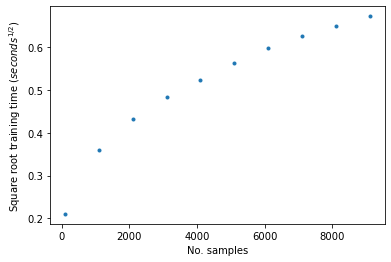

In [12]:
plt.plot(Ns, np.sqrt(np.mean(times,axis=0)), ".")
plt.xlabel("No. samples")
plt.ylabel("Square root training time ($seconds^{1/2}$)")
plt.show()

In [13]:
root_mean_times = np.sqrt(np.mean(times,axis=0))
m = root_mean_times[-1] / Ns[-1]
m

7.381916975282721e-05

In [14]:
# Time it takes for 9000 samples
(m * 9100)

0.6717544447507277

In [15]:
N_train = X_train.shape[0]
pred_secs = (m * N_train)**2 #answer in seconds
print("Predicted training time in minutes", pred_secs / 60) # answer in minutes

Predicted training time in minutes 0.3360534947737055


In [16]:
# fitting the classifier
clf = XGBRegressor()
start = time()
clf.fit(X_train, y_train) #train model and time
time() - start

1.94195556640625

How good is the out the box model?

In [17]:
from accel.training import score

In [18]:
y_pred = clf.predict(X_val)

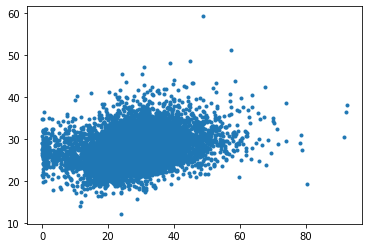

In [19]:
plt.plot(y_val,y_pred, ".")

In [20]:
score(y_val, y_pred)

MSE is:  76.5455867530804
R2 is:  0.09113863008452427
Explained variance is: 0.09129277045674622


(<function sklearn.metrics._regression.r2_score(y_true, y_pred, *, sample_weight=None, multioutput='uniform_average')>,
 <function sklearn.metrics._regression.mean_squared_error(y_true, y_pred, *, sample_weight=None, multioutput='uniform_average', squared=True)>,
 <function sklearn.metrics._regression.explained_variance_score(y_true, y_pred, *, sample_weight=None, multioutput='uniform_average')>)

# Hyper-parameter tuning
We perform hyper-parameter tuning on the linear SVM since it is less time-consuming to fit

In [21]:
from accel.training import model_tune

In [22]:
y_train.std()

9.311881251340733

In [23]:
# define lists of params interested in

# Number of trees in random forest
n_estimators = [10, 25, 50, 100, 150]
# Maximum number of levels in tree
max_depth = [6, 10, 50]
max_depth.append(None)
# The learning rate used to weight each model
learning_rate = [0.3, 0.1, 0.01, 0.001]
# Subsample ratio of the training instance
subsample = [0.7, 1.0]
# L2 regularisation
reg_lambda = [0.0, 0.5, 0.7, 1.0]
# L1 regularisation
reg_alpha = [0.0, 0.5, 0.7, 1.0]

# Create the grid
params = {'n_estimators': n_estimators,
               'learning_rate': learning_rate,
               'max_depth': max_depth,
               'subsample': subsample,
               'reg_lambda': reg_lambda,
               'reg_alpha': reg_alpha}

In [24]:
# Get the optimal parameters
model_tune(XGBRegressor(), 
                 params, X_train, y_train, X_val, y_val, 30)

Fitting 1 folds for each of 1 candidates, totalling 1 fits
Fitting 1 folds for each of 1 candidates, totalling 1 fits
Fitting 1 folds for each of 1 candidates, totalling 1 fits
Fitting 1 folds for each of 1 candidates, totalling 1 fits
Fitting 1 folds for each of 1 candidates, totalling 1 fits
Fitting 1 folds for each of 1 candidates, totalling 1 fits
Fitting 1 folds for each of 1 candidates, totalling 1 fits
Fitting 1 folds for each of 1 candidates, totalling 1 fits
Fitting 1 folds for each of 1 candidates, totalling 1 fits
Fitting 1 folds for each of 1 candidates, totalling 1 fits
Fitting 1 folds for each of 1 candidates, totalling 1 fits
Fitting 1 folds for each of 1 candidates, totalling 1 fits
Fitting 1 folds for each of 1 candidates, totalling 1 fits
Fitting 1 folds for each of 1 candidates, totalling 1 fits
Fitting 1 folds for each of 1 candidates, totalling 1 fits
Fitting 1 folds for each of 1 candidates, totalling 1 fits
Fitting 1 folds for each of 1 candidates, totalling 1 fi

/cdthome/xqe353/.conda/envs/cdt_wearables/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 1 folds for each of 1 candidates, totalling 1 fits


/cdthome/xqe353/.conda/envs/cdt_wearables/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 1 folds for each of 1 candidates, totalling 1 fits


/cdthome/xqe353/.conda/envs/cdt_wearables/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 1 folds for each of 1 candidates, totalling 1 fits
Fitting 1 folds for each of 1 candidates, totalling 1 fits
Fitting 1 folds for each of 1 candidates, totalling 1 fits


/cdthome/xqe353/.conda/envs/cdt_wearables/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 1 folds for each of 1 candidates, totalling 1 fits
Fitting 1 folds for each of 1 candidates, totalling 1 fits
Best parameter combo: OrderedDict([('learning_rate', 0.1), ('max_depth', None), ('n_estimators', 50), ('reg_alpha', 0.0), ('reg_lambda', 0.7), ('subsample', 0.7452772407929079)])
Best validation MSE: 1.0661091900703545e-01


BayesSearchCV(cv=PredefinedSplit(test_fold=array([-1, -1, ...,  0,  0])),
              estimator=XGBRegressor(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     enable_categorical=False, gamma=None,
                                     gpu_id=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_we...
                                     random_state=None, reg_alpha=None,
                                     reg_lambda=None, scale_pos_weight=None,
                                     subsample=None, tree_method=None,
                                     validate_parameters=None, verbosity=None),
              n_

Best parameters: <br>
**reg_lambda**:0.7 <br>
**max_depth**: None <br>
**reg_alpha**: 0.0 <br>
**subsample**: 0.7452772407929079 <br>
**learning_rate**: 0.1 <br>
**n_estimators**: 50 <br>

In [25]:
clf = XGBRegressor(reg_lambda=0.7, max_depth=None, reg_alpha=0, learning_rate = 0.1, subsample = 0.7452772407929079, n_estimators = 50)
clf.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.1, max_delta_step=0,
             max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=50, n_jobs=3,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=0.7, scale_pos_weight=1, subsample=0.7452772407929079,
             tree_method='exact', validate_parameters=1, verbosity=None)

MSE is:  75.24248875245029
R2 is:  0.10661091900703545
Explained variance is: 0.10728670145505637


(<function sklearn.metrics._regression.r2_score(y_true, y_pred, *, sample_weight=None, multioutput='uniform_average')>,
 <function sklearn.metrics._regression.mean_squared_error(y_true, y_pred, *, sample_weight=None, multioutput='uniform_average', squared=True)>,
 <function sklearn.metrics._regression.explained_variance_score(y_true, y_pred, *, sample_weight=None, multioutput='uniform_average')>)

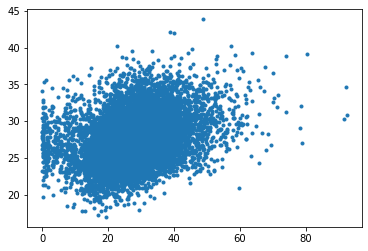

In [26]:
y_pred = clf.predict(X_val)
plt.plot(y_val,y_pred, ".")
score(y_val, y_pred)

## Full Model

In [28]:
X_train, X_val, X_test, y_train, y_val, y_test, means_modes = prep_data("/cdtshared/wearables/students/group5/eliminated-missing-participants.csv",
                                                                        normalise = True,
                                                                        one_hot = True)

In [29]:
clf = XGBRegressor()
start = time()
clf.fit(X_train, y_train) #train model and time
time() - start

18.10606050491333

In [30]:
model_tune(XGBRegressor(), 
                 params, X_train, y_train, X_val, y_val, 30)

Fitting 1 folds for each of 1 candidates, totalling 1 fits
Fitting 1 folds for each of 1 candidates, totalling 1 fits
Fitting 1 folds for each of 1 candidates, totalling 1 fits
Fitting 1 folds for each of 1 candidates, totalling 1 fits
Fitting 1 folds for each of 1 candidates, totalling 1 fits
Fitting 1 folds for each of 1 candidates, totalling 1 fits
Fitting 1 folds for each of 1 candidates, totalling 1 fits
Fitting 1 folds for each of 1 candidates, totalling 1 fits
Fitting 1 folds for each of 1 candidates, totalling 1 fits
Fitting 1 folds for each of 1 candidates, totalling 1 fits
Fitting 1 folds for each of 1 candidates, totalling 1 fits
Fitting 1 folds for each of 1 candidates, totalling 1 fits
Fitting 1 folds for each of 1 candidates, totalling 1 fits
Fitting 1 folds for each of 1 candidates, totalling 1 fits
Fitting 1 folds for each of 1 candidates, totalling 1 fits
Fitting 1 folds for each of 1 candidates, totalling 1 fits


/cdthome/xqe353/.conda/envs/cdt_wearables/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 1 folds for each of 1 candidates, totalling 1 fits


/cdthome/xqe353/.conda/envs/cdt_wearables/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 1 folds for each of 1 candidates, totalling 1 fits


/cdthome/xqe353/.conda/envs/cdt_wearables/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 1 folds for each of 1 candidates, totalling 1 fits


/cdthome/xqe353/.conda/envs/cdt_wearables/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 1 folds for each of 1 candidates, totalling 1 fits


/cdthome/xqe353/.conda/envs/cdt_wearables/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 1 folds for each of 1 candidates, totalling 1 fits


/cdthome/xqe353/.conda/envs/cdt_wearables/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 1 folds for each of 1 candidates, totalling 1 fits


/cdthome/xqe353/.conda/envs/cdt_wearables/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 1 folds for each of 1 candidates, totalling 1 fits


/cdthome/xqe353/.conda/envs/cdt_wearables/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 1 folds for each of 1 candidates, totalling 1 fits
Fitting 1 folds for each of 1 candidates, totalling 1 fits
Fitting 1 folds for each of 1 candidates, totalling 1 fits
Fitting 1 folds for each of 1 candidates, totalling 1 fits
Fitting 1 folds for each of 1 candidates, totalling 1 fits
Fitting 1 folds for each of 1 candidates, totalling 1 fits
Fitting 1 folds for each of 1 candidates, totalling 1 fits
Best parameter combo: OrderedDict([('learning_rate', 0.1), ('max_depth', None), ('n_estimators', 50), ('reg_alpha', 0.0), ('reg_lambda', 0.7), ('subsample', 0.9275744954144292)])
Best validation MSE: 1.8476674973612228e-01


BayesSearchCV(cv=PredefinedSplit(test_fold=array([-1, -1, ...,  0,  0])),
              estimator=XGBRegressor(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     enable_categorical=False, gamma=None,
                                     gpu_id=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_we...
                                     random_state=None, reg_alpha=None,
                                     reg_lambda=None, scale_pos_weight=None,
                                     subsample=None, tree_method=None,
                                     validate_parameters=None, verbosity=None),
              n_

Best parameters: <br>
**reg_lambda**:0.7 <br>
**max_depth**: None <br>
**reg_alpha**: 0.0 <br>
**subsample**: 0.9275744954144292 <br>
**learning_rate**: 0.1 <br>
**n_estimators**: 50 <br>

In [31]:
model = XGBRegressor(reg_lambda=0.7, max_depth=None, reg_alpha=0, learning_rate = 0.1, subsample = 0.9275744954144292, n_estimators = 50)
model.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.1, max_delta_step=0,
             max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=50, n_jobs=3,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=0.7, scale_pos_weight=1, subsample=0.9275744954144292,
             tree_method='exact', validate_parameters=1, verbosity=None)

MSE is:  68.66009442988296
R2 is:  0.18476674973612228
Explained variance is: 0.18538742143391806


(<function sklearn.metrics._regression.r2_score(y_true, y_pred, *, sample_weight=None, multioutput='uniform_average')>,
 <function sklearn.metrics._regression.mean_squared_error(y_true, y_pred, *, sample_weight=None, multioutput='uniform_average', squared=True)>,
 <function sklearn.metrics._regression.explained_variance_score(y_true, y_pred, *, sample_weight=None, multioutput='uniform_average')>)

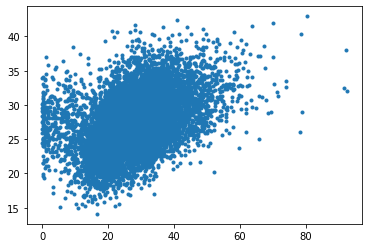

In [32]:
y_pred = model.predict(X_val)
plt.plot(y_val,y_pred, ".")
score(y_val, y_pred)

# Feature Importance

In [33]:
# organise features by importance
sorted_tuples = list(zip(model.feature_importances_, X_train.columns))
sorted_tuples.sort(key=lambda tup: tup[0])
importance, feature = zip(*sorted_tuples)

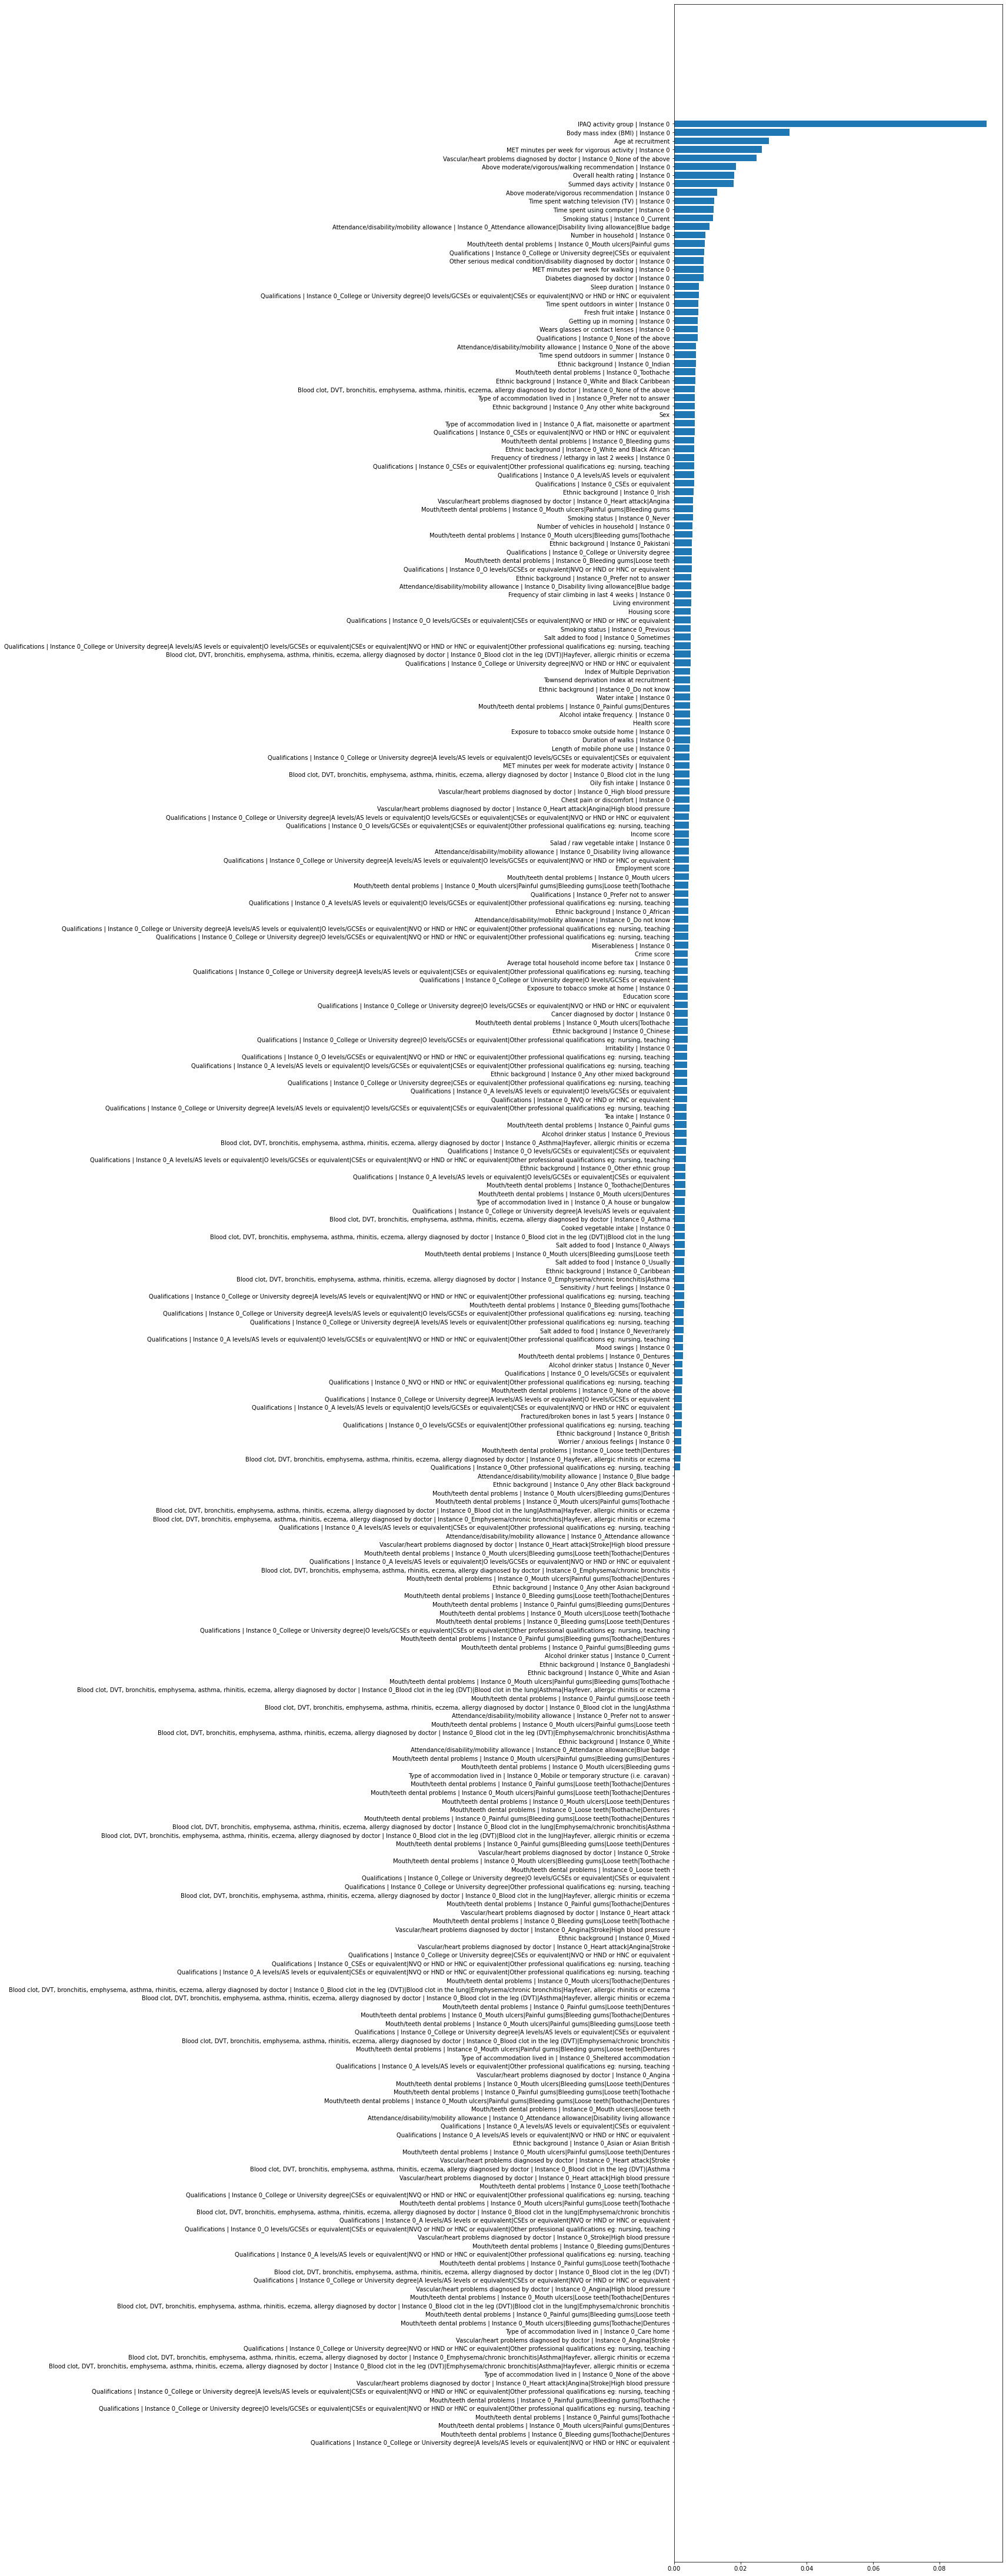

In [34]:
plt.figure(figsize=(10,80))
plt.barh(np.arange(len(importance)), importance, tick_label=feature)
plt.show()

# Test

In [35]:
X = np.vstack((X_train, X_val))
y = np.concatenate([y_train, y_val])

In [36]:
model = XGBRegressor(reg_lambda=0.7, max_depth=None, reg_alpha=0, learning_rate = 0.1, subsample = 0.9275744954144292, n_estimators = 50)
model.fit(X, y)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.1, max_delta_step=0,
             max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=50, n_jobs=3,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=0.7, scale_pos_weight=1, subsample=0.9275744954144292,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [37]:
# Get the test set performance
score(y_test, model.predict(X_test))

MSE is:  71.14201108914962
R2 is:  0.17186897865351147
Explained variance is: 0.1722510801568048


(<function sklearn.metrics._regression.r2_score(y_true, y_pred, *, sample_weight=None, multioutput='uniform_average')>,
 <function sklearn.metrics._regression.mean_squared_error(y_true, y_pred, *, sample_weight=None, multioutput='uniform_average', squared=True)>,
 <function sklearn.metrics._regression.explained_variance_score(y_true, y_pred, *, sample_weight=None, multioutput='uniform_average')>)